In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
x5 = np.arange(-5, 5, 0.25)
x5

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
y5 = f(x5)
y5

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

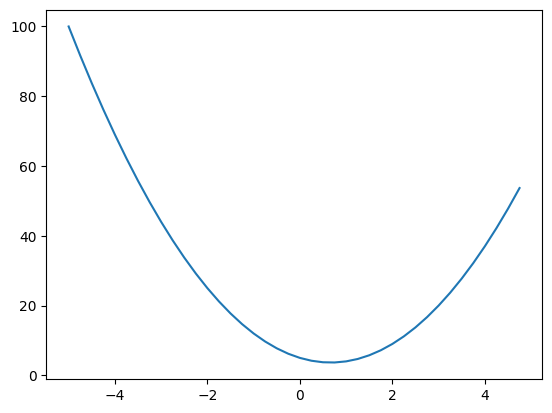

In [6]:
plt.plot(x5, y5)

In [7]:
h = 0.001
x = 3.0
f(x)

20.0

In [8]:
f(x+h)

20.014003000000002

In [9]:
(f(x+h)-f(x))

0.01400300000000243

In [10]:
(f(x+h)-f(x))/h

14.00300000000243

In [11]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [12]:
h = 0.0001

d1 = d
d2 = (a+h) * b + c
print("d1: ", d1)
print("d2: ", d2)
print("slope: ", (d2-d1)/h)

d1:  4.0
d2:  3.999699999999999
slope:  -3.000000000010772


In [13]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # Gradient of the Loss function wrt to this Value
    self._prev = set(_children) # Empty set
    self._op = _op
    self.label = label

    # Tells how we are going to chain output gradient with the input gradient
    # to find the node's gradient (mainly depends on whether the operation is
    # a '+', '*' and so on)
    self._backward = lambda: None # Empty function to start with.

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return (self + -other)

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out

  def tanh(self):
    out = Value(math.tanh(self.data), (self, ), 'tanh')

    def _backward():
      self.grad += (1 - out.data**2) * out.grad

    out._backward = _backward
    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    # Call it on this node
    build_topo(self)

    # Init
    self.grad = 1.0

    # The actual backpropagation happens here.
    for node in reversed(topo):
      node._backward()

In [14]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
e = a*b; e.label = 'e'

c = Value(10.0, label = 'c')

d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [15]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


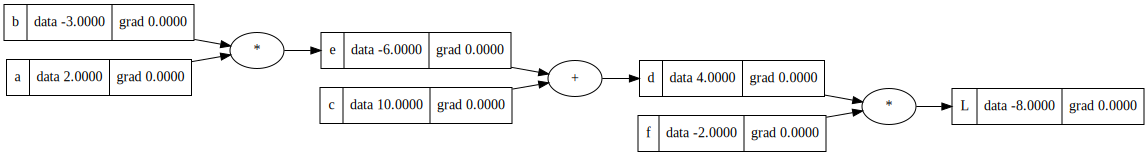

In [16]:
draw_dot(L)

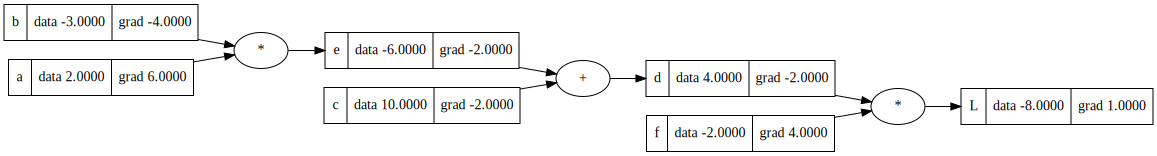

In [17]:
# Starting at L and working backward.
# Setting L.grad (gradient of L wrt L) to 1.

L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
b.grad = -4.0
a.grad = 6.0

draw_dot(L)

In [18]:
# All the lead nodes we have control over.
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

In [19]:
# Re-run the forward pass to avaluate L and update the intermediate nodes.

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


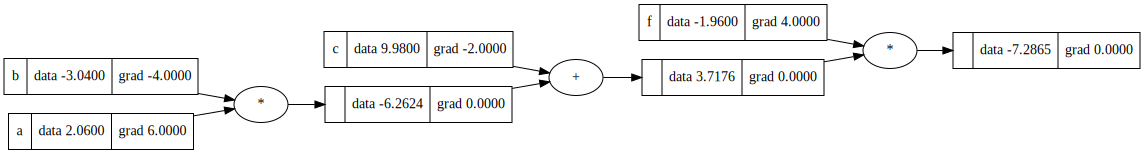

In [20]:
draw_dot(L)

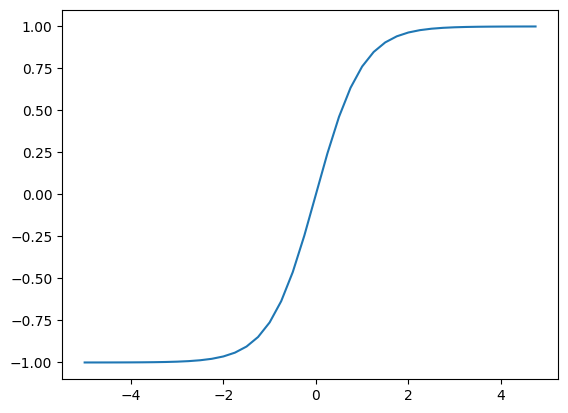

In [21]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25)))

In [22]:
# A simple neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Value of the neuron (x1w1 + x2w2 + b)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Raw output (wihtout the activation function)
n = x1w1x2w2 + b; n.label = 'n'

# Output (tanh needs to be implemented though)
o = n.tanh(); o.label = 'o'



In [23]:
# The neuron is ready.
# Forward-pass is working - meaning, when the input/leaf nodes are given their values, we are able to compute the output.

In [24]:
# We now start with the back-propagation for this single neuron.

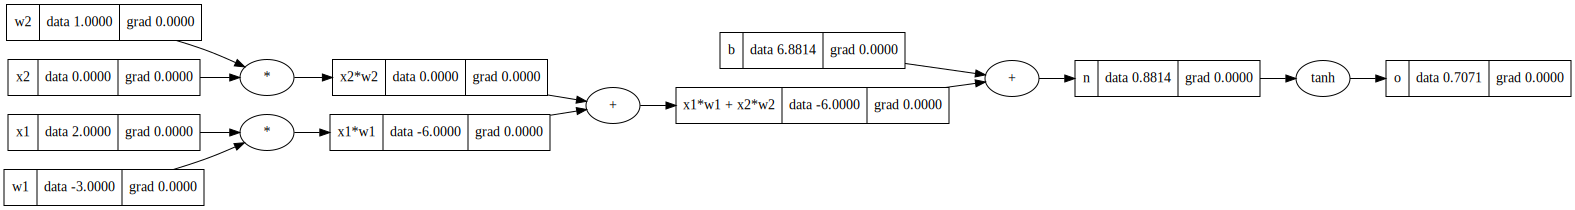

In [25]:
 draw_dot(o)

In [26]:
# Base case (will always be 1)
o.grad = 1

In [27]:
# What is do/dn?

# o = tanh(n)
# do/dn = tanh'(n)
# do/dn = 1-tanh(n)**2
# do/dn = 1-o**2
n.grad = 1-(o.data)**2
n.grad

0.4999999999999998

In [28]:
# Moving backward, what is x1w1x2w2.grad?
# The local derivative of the '+' sign is simply 1.
# So,

x1w1x2w2.grad = 1 * n.grad
b.grad = 1 * n.grad
print(x1w1x2w2.grad)
print(b.grad)

0.4999999999999998
0.4999999999999998


In [29]:
# Moving backward, x1w1x2w2 is simply made up of x1w2 + x2w2
# Because of the '+' sign, the local derivative is 1.00
# So,

x1w1.grad = 1 * x1w1x2w2.grad
x2w2.grad = 1 * x1w1x2w2.grad
print(x1w1.grad)
print(x2w2.grad)

0.4999999999999998
0.4999999999999998


In [30]:
# Moving backward, we are the first layer: 2 inputs, 2 corresponding weights.
# The multiplicative sign ends up in a different local derivative than the '+' sign.
# x1w1 = x1 * w1.

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
print(x1.grad)
print(w1.grad)
print(x2.grad)
print(w2.grad)

-1.4999999999999993
0.9999999999999996
0.4999999999999998
0.0


In [31]:
# Now, automating the entire back-propagation method (aka write a backward pass)

In [32]:
o.grad = 1  # Initialization is critical.

o._backward()

In [33]:
n._backward()

In [34]:
x1w1x2w2._backward()

In [35]:
x1w1._backward()
x2w2._backward()

In [36]:
# Implementing topological sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

# The code itself intuitively describes what topological sort is
# It visits all its children before adding itself to the visited set (look at the call to build_topo before topo.append(v)).
# That is all it does. It basically visits all its children/dependencies first before adding itself.

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865477)]

In [37]:
o.grad = 1

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
  node._backward()

In [38]:
o.backward()

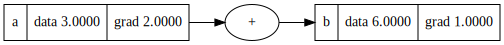

In [39]:
# A potential bug
a = Value(3.0, label = 'a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [40]:
# What about expressions like a+1? or a*2? or a/2?
2*a

Value(data=6.0)

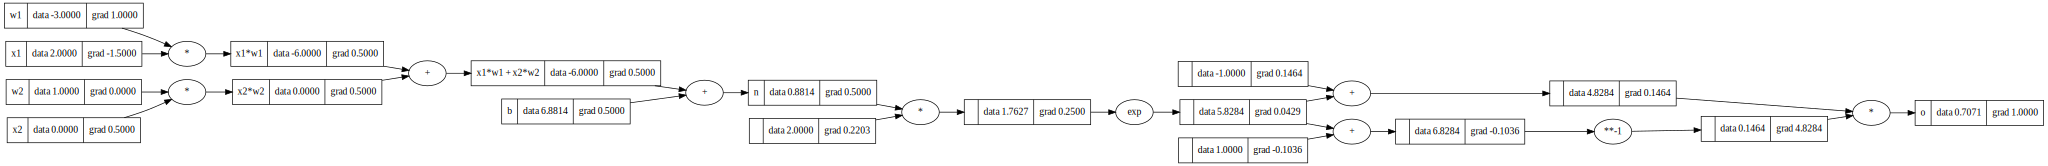

In [41]:
# A simple neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# Value of the neuron (x1w1 + x2w2 + b)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# Raw output (wihtout the activation function)
n = x1w1x2w2 + b; n.label = 'n'

# Output (tanh needs to be implemented though)
# Changing how o is implemented.
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'

o.backward()
draw_dot(o)

In [42]:
# The same thing in pytorch

import torch

x1 = torch.Tensor([2.0]).double()       ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()       ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [43]:
vec = torch.Tensor([[1,2,3], [4,5,6]])

In [44]:
# Start of implementation of Neural Network, MLP Network.

In [45]:
import random

class Neuron:
  def __init__(self, nin):
    # nin = No. of inputs

    # A neuron has 2 types of parameters:
    # 1. Weights (No. of weights = No. of inputs to the neuron)
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]

    # 2. The Bias (b)
    self.b = Value(random.uniform(-1, 1))

    # Here, parameters are initialized to a random number between -1 & 1.

  def __call__(self, x):
    # w * x + b
    # This is essentially the following:
    # n = Neuron(2)
    # n(x) <---- This function-call (using the object's name calls __call__ internally)
    activation = self.b
    for i in range(len(self.w)):
      activation += self.w[i]*x[i]

    return activation.tanh()

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    # A layer of Neurons has: No. of Inputs and No. of Outputs
    # Each Neuron in the layer has nin Inputs.
    # Number of neurons in this layer = nout (no. of outputs arising from this layer)
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    # It takes in No. of Inputs and a list of neurons in each layer as input
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [46]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.24633542145720239)

In [47]:
n.parameters()

[Value(data=-0.7707496412624364),
 Value(data=0.16216620724325037),
 Value(data=-0.36514955012443906),
 Value(data=-0.7638755872605802),
 Value(data=0.11902103710694978),
 Value(data=-0.6390326939412887),
 Value(data=0.9427224056376435),
 Value(data=0.2739267200777289),
 Value(data=-0.4352983303401714),
 Value(data=0.9215251579368644),
 Value(data=0.3664644154986578),
 Value(data=0.9388925218429149),
 Value(data=-0.8052394447696611),
 Value(data=-0.7999033047974469),
 Value(data=0.26070246522117846),
 Value(data=-0.07863480239307385),
 Value(data=0.3017189023736475),
 Value(data=0.15940853314873937),
 Value(data=-0.9278528614945032),
 Value(data=-0.08014986800454604),
 Value(data=0.08381324225830666),
 Value(data=-0.7506935231291179),
 Value(data=0.01353622390689968),
 Value(data=0.18589441597420953),
 Value(data=0.3881537037572116),
 Value(data=0.06955609598260981),
 Value(data=-0.049714104894044375),
 Value(data=-0.9544914171920205),
 Value(data=-0.3660168348108588),
 Value(data=-0.0

In [48]:
# Sample Dataset

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired Targets

In [49]:
# The Forward Pass (calculating the loss function)

ypred = [n(x) for x in xs]
diffs = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss = diffs[0] + diffs[1] + diffs[2] + diffs[3]
loss

Value(data=4.383380424550586)

In [50]:
# The Backward Pass (Calling backward and calculating gradients of each
# data point and parameter (for us, grad of only parameter is important))
loss.backward()

In [51]:
# Fine-tune each parameter based on its gradient.
# Going in the direction of the gradient will increase the function
# We want to reduce/optimize the loss function => We go in the opposite direction.
# By how much quantity do we go? We can choose that (that is a hyperparameter),
# for now, let us keep it as 0.1.

params = n.parameters()
for p in params:
  p.data += -0.009 * p.grad

In [52]:
# Actual outputs
y_actual = [n(x) for x in xs]
y_actual

[Value(data=0.3007743112558692),
 Value(data=0.2662483955050607),
 Value(data=-0.05371544610613243),
 Value(data=0.23030585792425884)]

In [53]:
n.parameters() # We don't know what these values mean though

[Value(data=-0.7750113905710194),
 Value(data=0.15767255670982466),
 Value(data=-0.35826322956867274),
 Value(data=-0.7658190561104833),
 Value(data=0.12106455759757588),
 Value(data=-0.6356080422405592),
 Value(data=0.9450119116257379),
 Value(data=0.27729670039201626),
 Value(data=-0.4333868466271525),
 Value(data=0.9217465449150706),
 Value(data=0.3665828558949748),
 Value(data=0.9400032984773186),
 Value(data=-0.8000297040120641),
 Value(data=-0.7976580676072638),
 Value(data=0.26497343875802304),
 Value(data=-0.0740171489519033),
 Value(data=0.29994235890308457),
 Value(data=0.16343612000126087),
 Value(data=-0.929488792327376),
 Value(data=-0.08136411382314812),
 Value(data=0.08546126194140499),
 Value(data=-0.7420217413762813),
 Value(data=-0.017922875839281996),
 Value(data=0.2010151571718718),
 Value(data=0.3924071419106324),
 Value(data=0.06240372760967369),
 Value(data=-0.060790042197977276),
 Value(data=-0.9245778123260919),
 Value(data=-0.3797233652637243),
 Value(data=-0.

In [54]:
# Automate the entire training process
# The awesome gradient descent

for k in range(100):

  # 1. Forward Pass

  ypred = [n(x) for x in xs]
  diffs = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
  loss = diffs[0] + diffs[1] + diffs[2] + diffs[3]

  # 2. Backward Pass
  # The Backward Pass (Calling backward and calculating gradients of each
  # data point and parameter (for us, grad of only parameter is important))
  params = n.parameters()
  for p in params:
    p.grad = 0.0
  loss.backward()

  # 3. Fine-Tune the parameters
  # Fine-tune each parameter based on its gradient.
  # Going in the direction of the gradient will increase the function
  # We want to reduce/optimize the loss function => We go in the opposite direction.
  # By how much quantity do we go? We can choose that (that is a hyperparameter),
  # for now, let us keep it as 0.1.

  for p in params:
    p.data += -0.009 * p.grad

  print(k, loss.data)

0 3.580185092202672
1 2.8365562675088722
2 2.227546109853143
3 1.7807386807583654
4 1.4653097504309482
5 1.2386570045946856
6 1.0700034439507897
7 0.9401889972281335
8 0.8373621643746328
9 0.7539599293170904
10 0.684975020038949
11 0.6269762596691923
12 0.5775395805710031
13 0.5349059048857738
14 0.4977683679587692
15 0.4651358160275407
16 0.4362427420307905
17 0.4104883341642084
18 0.38739426911334873
19 0.3665748714703519
20 0.34771561456046046
21 0.33055736331768637
22 0.3148846441265657
23 0.30051678745939164
24 0.2873011523337112
25 0.2751078813184853
26 0.2638257958475795
27 0.25335915157584615
28 0.2436250497840416
29 0.23455135449639153
30 0.2260750032305755
31 0.21814062691709635
32 0.21069941469562964
33 0.20370817418935422
34 0.19712854896796905
35 0.1909263632771413
36 0.18507107047046356
37 0.17953528645289601
38 0.1742943932089732
39 0.1693262004188472
40 0.16461065546170556
41 0.16012959391821383
42 0.1558665241225965
43 0.15180644046450176
44 0.14793566106430237
45 0.14

In [55]:
# Actual outputs
y_actual = [n(x) for x in xs]
print(y_actual)
print(loss)

[Value(data=0.900098020175996), Value(data=-0.9416034952866436), Value(data=-0.841006172745247), Value(data=0.8617307854692868)]
Value(data=0.05846332048827359)
